`nb_conda_kernels` shows conda environments as Jupyter kernels

Read in data

In [1]:
from pathlib import Path
import pandas as pd
from zipfile import ZipFile
suffix = ".parquet"

prefixes = ["data-trimmed.zip"]

_dfs = {}
for prefix in prefixes:
    with ZipFile(prefix, "r") as zf:
        for k, f in enumerate(zf.infolist()):
            if k % 200 == 0:
                print(k / len(zf.infolist()))
            fname = f.orig_filename.split("/")[-1]
            if not fname:
                continue
            with zf.open(f) as fi:
                _df = pd.read_parquet(fi)
            _dfs[fname] = _df
    
train_dfs = {name.replace(suffix, ""): df for name, df in _dfs.items() if "-train" in name}
dfs = {name.replace(suffix, ""): df for name, df in _dfs.items() if "-train" not in name}

# assert len(train_dfs) + len(dfs) == len(_dfs)
# print("Train dataframe:", len(train_dfs))
print("Test dataframe:", len(dfs))

0.0
0.4024144869215292
0.8048289738430584
Test dataframe: 248


### Get seeds, and make sure they're all the same

In [2]:
from typing import Any
import numpy as np

def _get_unique(series: pd.Series, ignore_null=False) -> Any:
    if ignore_null:
        series = series[~series.isnull()]
    assert series.nunique() == 1
    return series.unique()[0]


N_SEEDS = 50
possible_seeds = np.array([_get_unique(df.seed) for df in dfs.values()])
seeds = np.arange(possible_seeds.min(), possible_seeds.min() + N_SEEDS + 0).astype(int)
assert len(seeds) == N_SEEDS

good_names = {name for name, df in dfs.items() if _get_unique(df.seed) in seeds}
_dfs = [dfs[name] for name in good_names]
# print(train_dfs.keys())
_train_dfs = [train_dfs[f"{name}-train"] for name in good_names]

df = pd.concat(_dfs, sort=False)
train_df = pd.concat(_train_dfs, sort=False)

# idx = df.seed.isin(seeds)
# assert idx.sum() / len(idx) < 1.0
# df = df.loc[idx].copy()
# idx = train_df.seed.isin(seeds)
# train_df = train_df[idx].copy()

Make sure all the best test losses are the same

In [3]:
best_test_losses = df.groupby(["damper", "seed"])["best_test_loss"].unique()
assert all(best_test_losses.apply(len) == 1)
assert best_test_losses.apply(lambda x: x[0]).nunique()

In [4]:
assert (df.groupby("damper")["seed"].unique().apply(len) == N_SEEDS).all()

In [5]:
df.groupby("damper")["seed"].nunique()

damper
adadamp       50
adagrad       50
cntsdamplr    50
gd            50
Name: seed, dtype: int64

In [6]:
df.damper.unique()

array(['adagrad', 'gd', 'cntsdamplr', 'adadamp'], dtype=object)

In [7]:
df.pivot_table(
    columns="damper",
    values="lr",
    aggfunc=_get_unique,
)

damper,adadamp,adagrad,cntsdamplr,gd
lr,0.0025,0.0025,0.0025,0.0025


In [8]:
df.pivot_table(
    index="damper",
    values="batch_size",
    aggfunc="max",
).T

damper,adadamp,adagrad,cntsdamplr,gd
batch_size,74342.0,64.0,64.0,8051.0


In [9]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from typing import Optional, Union, List
plt.style.use("seaborn-colorblind")

Data = Union[pd.DataFrame]
AxesSubplot = mpl.axes._axes.Axes
Number = Union[int, float]

def lineplot(
    x:Optional[str]=None,
    y:Optional[str]=None,
    data:Optional[Data]=None,
    hue:Optional[str]=None,
    ax:Optional[AxesSubplot]=None,
    ci:Optional[str]=None,
    hue_order:Optional[List[str]] = None,
    hues=None,
    styles=None,
    bin:Optional[Union[bool, int]] = None,
    aggfunc="mean",
    style="-",
):
    if isinstance(bin, bool):
        bin = 0
    df = data
    if ci is not None and ci not in ["boxplot", "percentile"]:
        raise ValueError(f"ci={ci} not recognized")
    if ax is None:
        fig, ax = plt.subplots()
    if hue_order is None:
        hue_order = list(sorted(df[hue].unique()))
    if hues is None:
        hues = [f"C{k}" for k in range(len(hue_order))]
    if styles is None:
        styles = ["-"] * len(hue_order)
    for k, hue_value in enumerate(hue_order):
        idx = df[hue] == hue_value
        _show = df[idx]
#         print(hue_value)
        
        if bin is not None:
            _show = _show.copy()
            _show[x] = np.round(_show[x], decimals=bin)
            
        if isinstance(aggfunc, str):
            _aggfunc = getattr(np, aggfunc)
        elif callable(aggfunc):
            _aggfunc = aggfunc
        else:
            raise ValueError(f"aggfunc={aggfunc} not str or callable")
        s = _show.pivot_table(index=x, values=y, aggfunc=_aggfunc)
        if len(s):
            print(styles[k], hues[k])
            ax.plot(s.index, s.values, linestyle=styles[k], color=hues[k], label=hue_value)
        if ci in ["boxplot", "percentile"]:
            _lower = _show.pivot_table(index=x, values=y, aggfunc=lambda x: np.percentile(x, 25))
            _upper = _show.pivot_table(index=x, values=y, aggfunc=lambda x: np.percentile(x, 75))
            assert np.allclose(_lower.index, _upper.index)
            ax.fill_between(_lower.index, _lower.values.flatten(), _upper.values.flatten(), color=hues[k], alpha=0.2)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.legend(loc="best")
    
        
    return ax

In [10]:
# idx = ~df.damper.isin(["sgd"])
idx = [True] * len(df)
# idx &= df.epochs < np.floor(df.epochs.max())
idx &= df.epochs <= 70 + 0.5
show = df[idx].copy()
# show = df[df.seed == 30].copy()
# show["test_loss_diff"] = show.test_loss #- show.test_loss.min()#show.best_test_loss
# show.test_loss_diff -= 1

# def loground(x, decimals=0.5):
#     assert decimals > 0
#     y = x / decimals
#     z = np.round(y)
#     print(x.values)
#     print(y.values)
#     print(z.values)
#     print((z * decimals).values)
#     return z * decimals
    
    
idx = show.damper == "adadamp"
show.loc[idx, "epochs"] = np.round(show.loc[idx, "epochs"])
m = 5
show.loc[idx, "model_updates"] = np.round(m * show.loc[idx, "model_updates"]) / m

show.loc[idx, "damper"] = "Adaptive\nBatch SGD"
show.loc[show.damper == "adagrad", "damper"] = "AdaGrad"
show.loc[show.damper == "geodamplr", "damper"] = "GeoDampLR"
show.loc[show.damper == "cntsdamplr", "damper"] = "SGD"
show.loc[show.damper == "gd", "damper"] = "Gradient\ndescent"

print(show.groupby("damper")["epochs"].agg(["min", "max"]))

                     min        max
damper                             
AdaGrad              0.0  70.113029
Adaptive\nBatch SGD  0.0  70.000000
Gradient\ndescent    0.0  70.000000
SGD                  0.0  70.113029


In [11]:
DAMPERS = ["Adaptive\nBatch SGD", "AdaGrad", "SGD", "Gradient\ndescent"]
COLORS = ["C0", "C3", "C2", "C1"]
STYLES = ["-", "-.", "--", (0, (5, 1))]

In [12]:
w = 2.75

- C0
-. C3
-- C2
(0, (5, 1)) C1
epochs
- C0
-. C3
-- C2
(0, (5, 1)) C1
updates


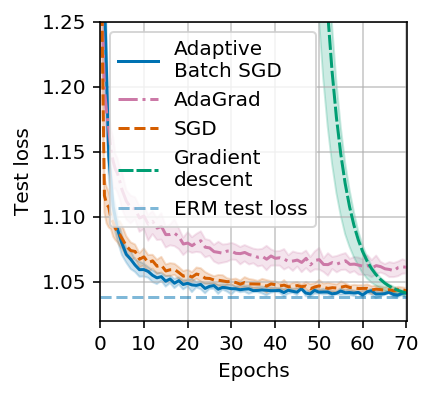

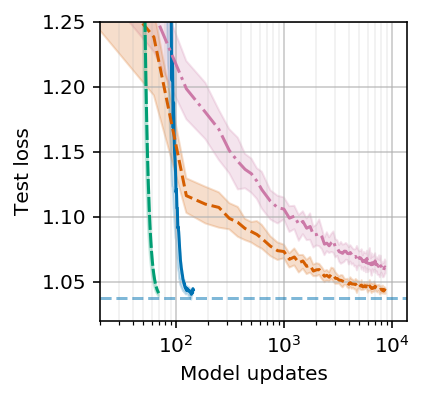

In [13]:
for x in ["epochs", "model_updates"]:
    fig, ax = plt.subplots(figsize=(w, w))
    ax = lineplot(
        data=show,
        x=x,
        y="test_loss",
        hue="damper",
        aggfunc="mean",
        ci="boxplot",
        hue_order=DAMPERS,
        hues=COLORS,
        styles=STYLES,
        ax=ax,
#         style="o-",
    )
    if "epoch" in x:
#         _ = ax.set_xscale("log")
#         _ = ax.set_xlim(0.1, None)
        _ = ax.set_xlabel("Epochs")
        _ = ax.xaxis.set_major_locator(plt.MultipleLocator(10))
        _ = ax.margins(x=0)
        _ = ax.set_xlim(0, None)
    else:
        _ = ax.set_xscale("log")
        _ = ax.set_xlim(20, None)
        _ = ax.set_xlabel("Model updates")

    _ = ax.set_ylim(1.02, 1.25)
    _ = ax.set_ylabel("Test loss")
    erm_loss = _get_unique(show.best_test_loss)
    _ = ax.plot(ax.get_xlim(), [erm_loss, erm_loss], "--", label="ERM test loss", alpha=0.5)
    if "epoch" in x:
        legend = ax.legend(loc="upper left")
    else: 
#         legend = ax.legend(loc="upper right")
        ax.legend_.remove()
    ax.grid(alpha=0.7)
    ax.grid(alpha=0.2, which="minor")
    name = "updates" if "updates" in x else x
    print(name)
    plt.savefig(f"figs/synth-{name}.pdf", bbox_inches="tight")

In [14]:
adadamps = [tdf for tdf in train_dfs.values() if _get_unique(tdf.damper) == "adadamp"]
epochs = [_df for _df in dfs.values() if _get_unique(_df["damper"]) in ["sgd", "adagrad", "geodamplr", "cntsdamplr"]]
nunique = [e["damper"].nunique() == 1 for e in epochs]
assert all(nunique)

In [15]:
from pprint import pprint
epoch_scoring = pd.concat(epochs, sort=False)
update_scoring = pd.concat(adadamps, sort=False)
diff = set(epoch_scoring.columns) - set(update_scoring.columns)

epoch_cols = [
#     'best_train_loss',
    'model_updates',
    'num_examples',
    'epochs',
#     'train_loss',
    'test_loss',
    'damper',
    'batch_size'
]

update_cols = [
#     'best_train_loss',
    'model_updates',
    'num_examples',
    'epochs',
#     'train_loss',  # renamed from '_complete_loss',
    'damper',
    'batch_size', 
]
# update_scoring["train_loss"] = update_scoring["_complete_loss"]
show = pd.concat([epoch_scoring[epoch_cols], update_scoring[update_cols]], sort=False)

adadamp_scoring = [_df for _df in dfs.values() if _get_unique(_df["damper"]) in ["adadamp"]]
cols = ["test_loss", "epochs", "model_updates", "damper"]
adadamp_scoring = pd.concat([a[cols] for a in adadamp_scoring], sort=False)
show = pd.concat([adadamp_scoring, show], sort=False)

show["model_updates_p1"] = show["model_updates"] + 1
# show["train_loss_diff"] = show["train_loss"] - show["best_train_loss"]

# show = pd.concat([epoch_scoring, update_scoring], sort=False)

# show["test_loss_diff"] = show["test_loss"] - (show["best_test_loss"] - 0)
# show["train_loss_diff"] = show["train_loss"] - show["best_train_loss"]
# show["model_updates_p1"] = show["model_updates"] + 1

146
- C0
767605.5613559404


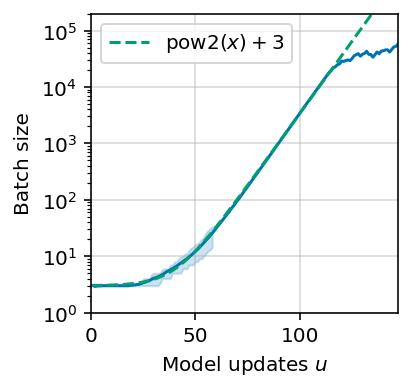

In [16]:
fig, ax = plt.subplots(figsize=(w, w))

s = show[show.damper == "adadamp"].copy()
s["damper"] = "Adaptive-SGD"
_x = np.arange(s.model_updates.min(), s.model_updates.max())
print(_x.max())
_y = np.clip(2 ** (0.17 * (_x - 32)), 3, show.batch_size.max())
_y = 2 ** (0.17 * (_x - 32)) + 3
# print(_y[800:])
# _y = np.clip(2 ** (0.17 * _x) + 2, 3, show.batch_size.max())


_exp = (0.17 * (_x - 31))
_y = 2**_exp + 3
ax = lineplot(
    data=s,
    x="model_updates",
    y="batch_size",
    hue="damper",
    aggfunc="mean",
    ax=ax,
    ci="boxplot",
)
xlim = s["model_updates"].max()
ax.set_xlim(0, xlim)
ax.set_yscale("log", basey=2)
ax.set_yscale("log", basey=10)
ax.grid(alpha=0.5)
# d = _get_unique(df.len_dataset)
# ax.plot(ax.get_xlim(), [d, d], "C2--", alpha=0.7, label="Number of training data")
ax.set_ylim(1, 2 * 10**5)

print(_y.max())
ax.set_ylabel("Batch size")
ax.set_xlabel("Model updates $u$")

line, = ax.plot(_x, _y, "C1--", label="pow2$(x) + 3$")
ax.legend((line, ), ("pow2$(x) + 3$", ), loc="best")

# ax.plot(ax.get_xlim(), [bs, bs], "C2", label="SGDs/Adagrad")
plt.savefig("figs/synth-batch-size.pdf", bbox_inches="tight")